In [12]:
### Import Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pybaseball as pyb

In [13]:
print(pyb.playerid_lookup('Gore','Mackenzie'))

Gathering player lookup table. This may take a moment.
  name_last name_first  key_mlbam key_retro key_bbref  key_fangraphs  \
0      gore  mackenzie     669022  gorem001  gorema01          22201   

   mlb_played_first  mlb_played_last  
0            2022.0           2024.0  


In [14]:
pitcher_id = 669022
df_pyb = pyb.statcast_pitcher('2024-03-28', '2024-10-01', pitcher_id)
df_pyb.head()

Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
0,CH,2024-08-23,87.3,1.54,5.80,"Gore, MacKenzie",593160,669022,strikeout,called_strike,...,1,1,2,Standard,Standard,129.0,-0.061,-0.231,NaN,NaN
1,CU,2024-08-23,83.1,1.38,6.01,"Gore, MacKenzie",593160,669022,NaN,ball,...,1,1,2,Standard,Standard,332.0,0.019,0.024,NaN,NaN
2,CU,2024-08-23,83.4,1.33,5.99,"Gore, MacKenzie",593160,669022,NaN,swinging_strike_blocked,...,1,1,2,Standard,Standard,331.0,0.000,-0.047,56.48919,8.47257
3,CU,2024-08-23,79.4,1.45,5.90,"Gore, MacKenzie",593160,669022,NaN,swinging_strike,...,1,1,2,Standard,Standard,337.0,0.000,-0.042,48.85066,7.58196
4,CH,2024-08-23,86.0,1.77,5.92,"Gore, MacKenzie",657656,669022,single,hit_into_play,...,1,1,2,Standard,Standard,131.0,0.023,0.113,74.00396,7.75517


In [15]:
def df_processing(df_pyb: pd.DataFrame):
    df = df_pyb.copy()
    # Define the codes for different types of swings and whiffs
    swing_code = ['foul_bunt','foul','hit_into_play','swinging_strike', 'foul_tip',
                'swinging_strike_blocked','missed_bunt','bunt_foul_tip']
    whiff_code = ['swinging_strike', 'foul_tip', 'swinging_strike_blocked']

    # Create new columns in the DataFrame to indicate swing, whiff, in-zone, out-zone, and chase
    df['swing'] = (df['description'].isin(swing_code))
    df['whiff'] = (df['description'].isin(whiff_code))
    df['in_zone'] = (df['zone'] < 10)
    df['out_zone'] = (df['zone'] > 10)
    df['chase'] = (df.in_zone==False) & (df.swing == 1)

    # Convert the pitch type to a categorical variable
    df['pfx_z'] = df['pfx_z'] * 12
    df['pfx_x'] = df['pfx_x'] * 12
    return df

df = df_processing(df_pyb)

In [17]:
df_statcast_group = pd.read_csv('statcast_2024_grouped.csv')

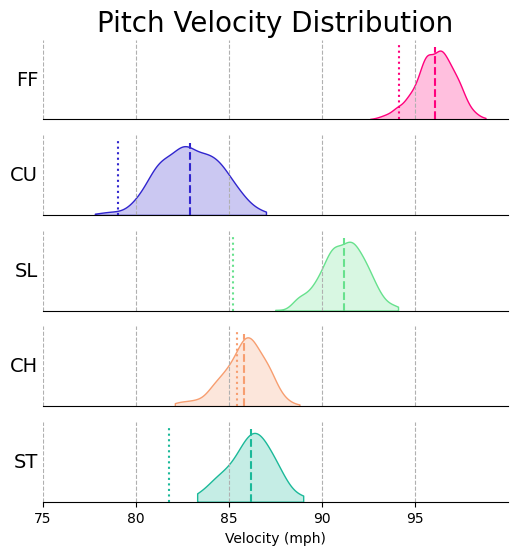

In [20]:
import math
import matplotlib.gridspec as gridspec

pitch_colours = {
    ## Fastballs ##
    'FF': {'colour': '#FF007D', 'name': '4-Seam Fastball'},
    'FA': {'colour': '#FF007D', 'name': 'Fastball'},
    'SI': {'colour': '#98165D', 'name': 'Sinker'},
    'FC': {'colour': '#BE5FA0', 'name': 'Cutter'},

    ## Offspeed ##
    'CH': {'colour': '#F79E70', 'name': 'Changeup'},
    'FS': {'colour': '#FE6100', 'name': 'Splitter'},
    'SC': {'colour': '#F08223', 'name': 'Screwball'},
    'FO': {'colour': '#FFB000', 'name': 'Forkball'},

    ## Sliders ##
    'SL': {'colour': '#67E18D', 'name': 'Slider'},
    'ST': {'colour': '#1BB999', 'name': 'Sweeper'},
    'SV': {'colour': '#376748', 'name': 'Slurve'},

    ## Curveballs ##
    'KC': {'colour': '#311D8B', 'name': 'Knuckle Curve'},
    'CU': {'colour': '#3025CE', 'name': 'Curveball'},
    'CS': {'colour': '#274BFC', 'name': 'Slow Curve'},
    'EP': {'colour': '#648FFF', 'name': 'Eephus'},

    ## Others ##
    'KN': {'colour': '#867A08', 'name': 'Knuckleball'},
    'PO': {'colour': '#472C30', 'name': 'Pitch Out'},
    'UN': {'colour': '#9C8975', 'name': 'Unknown'},
}

# Create a dictionary mapping pitch types to their colors
dict_colour = dict(zip(pitch_colours.keys(), [pitch_colours[key]['colour'] for key in pitch_colours]))
def velocity_kdes(df: pd.DataFrame,
                  ax: plt.Axes,
                  gs: gridspec,
                  gs_x: list,
                  gs_y: list,
                  fig: plt.Figure,
                  df_statcast_group: pd.DataFrame):

    # Get the count of each pitch type and sort them in descending order
    sorted_value_counts = df['pitch_type'].value_counts().sort_values(ascending=False)

    # Get the list of pitch types ordered from most to least frequent
    items_in_order = sorted_value_counts.index.tolist()

    # Turn off the axis and set the title for the main plot
    ax.axis('off')
    ax.set_title('Pitch Velocity Distribution', fontdict={'size': 20})

    # Create a grid for the inner subplots
    inner_grid_1 = gridspec.GridSpecFromSubplotSpec(len(items_in_order), 1, subplot_spec=gs[gs_x[0]:gs_x[-1], gs_y[0]:gs_y[-1]])
    ax_top = []

    # Create subplots for each pitch type
    for inner in inner_grid_1:
        ax_top.append(fig.add_subplot(inner))

    ax_number = 0

    # Loop through each pitch type and plot the velocity distribution
    for i in items_in_order:
        # Check if all release speeds for the pitch type are the same
        if np.unique(df[df['pitch_type'] == i]['release_speed']).size == 1:
            # Plot a single line if all values are the same
            ax_top[ax_number].plot([np.unique(df[df['pitch_type'] == i]['release_speed']),
                                    np.unique(df[df['pitch_type'] == i]['release_speed'])], [0, 1], linewidth=4,
                                   color=dict_colour[df[df['pitch_type'] == i]['pitch_type'].values[0]], zorder=20)
        else:
            # Plot the KDE for the release speeds
            sns.kdeplot(df[df['pitch_type'] == i]['release_speed'], ax=ax_top[ax_number], fill=True,
                        clip=(df[df['pitch_type'] == i]['release_speed'].min(), df[df['pitch_type'] == i]['release_speed'].max()),
                        color=dict_colour[df[df['pitch_type'] == i]['pitch_type'].values[0]])
        
        # Plot the mean release speed for the current data
        df_average = df[df['pitch_type'] == i]['release_speed']
        ax_top[ax_number].plot([df_average.mean(), df_average.mean()],
                               [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                               color=dict_colour[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                               linestyle='--')

        # Plot the mean release speed for the statcast group data
        df_average = df_statcast_group[df_statcast_group['pitch_type'] == i]['release_speed']
        ax_top[ax_number].plot([df_average.mean(), df_average.mean()],
                               [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                               color=dict_colour[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                               linestyle=':')

        # Set the x-axis limits
        ax_top[ax_number].set_xlim(math.floor(df['release_speed'].min() / 5) * 5, math.ceil(df['release_speed'].max() / 5) * 5)
        ax_top[ax_number].set_xlabel('')
        ax_top[ax_number].set_ylabel('')

        # Hide the top, right, and left spines for all but the last subplot
        if ax_number < len(items_in_order) - 1:
            ax_top[ax_number].spines['top'].set_visible(False)
            ax_top[ax_number].spines['right'].set_visible(False)
            ax_top[ax_number].spines['left'].set_visible(False)
            ax_top[ax_number].tick_params(axis='x', colors='none')

        # Set the x-ticks and y-ticks
        ax_top[ax_number].set_xticks(range(math.floor(df['release_speed'].min() / 5) * 5, math.ceil(df['release_speed'].max() / 5) * 5, 5))
        ax_top[ax_number].set_yticks([])
        ax_top[ax_number].grid(axis='x', linestyle='--')

        # Add text label for the pitch type
        ax_top[ax_number].text(-0.01, 0.5, i, transform=ax_top[ax_number].transAxes,
                               fontsize=14, va='center', ha='right')
        ax_number += 1

    # Hide the top, right, and left spines for the last subplot
    ax_top[-1].spines['top'].set_visible(False)
    ax_top[-1].spines['right'].set_visible(False)
    ax_top[-1].spines['left'].set_visible(False)

    # Set the x-ticks and x-label for the last subplot
    ax_top[-1].set_xticks(list(range(math.floor(df['release_speed'].min() / 5) * 5, math.ceil(df['release_speed'].max() / 5) * 5, 5)))
    ax_top[-1].set_xlabel('Velocity (mph)')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
velocity_kdes(df=df,
              ax=ax,
              gs=gridspec.GridSpec(1, 1),
              gs_x=[0, 1],
              gs_y=[0, 1],
              fig=fig,
              df_statcast_group=df_statcast_group)